In [1]:
%matplotlib inline
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import sceptre as spt

Normalisation factors should sum to one - check edgeR transformation

In [2]:
# from scp.models import PROTVI
# import scp.plots as pl
# import scp.utils as utils
# import scp.metrics as metrics

from protvi.benchmark_models import run_protDP
from protvi.utils import smoothing
import protvi
import protvi.plots as pl

import seaborn as sns

import scvi

from scib_metrics.benchmark import Benchmarker
import scib_metrics

In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [4]:
adata = sc.read('../../data/processed/Schoof_et_al_500ms_full.h5ad')

In [5]:
adata.obs.rename(columns = {'CD34 APC-Cy7-A': 'CD34-APC-Cy7-A', 'CD38 PE-A':'CD38-PE-A'}, inplace=True)
adata.obs["Num Proteins"] = np.sum(adata.X, axis=1)

adata.X[adata.X == 0] = np.nan
sc.pp.log1p(adata)

adata.layers["raw"] = adata.X.copy()

In [6]:
adata_booster = adata[adata.obs.Channel.isin(['126', '127C'])].copy()
adata = adata[~adata.obs.Channel.isin(['126', '127C'])].copy() 

In [7]:
# @TODO: add sceptre to h5ad file

#adata.layers['X_sceptre'] = adata.X.copy()
#adata.obsm['sceptre_X_pca'] = adata.obsm['X_pca']
#adata.obsm['sceptre_X_umap'] = adata.obsm['X_umap']
#adata.X = adata.layers['raw'].copy()

Filter and/or explore data before training

In [8]:
adata.X = adata.layers["raw"].copy()

detections = np.mean(~np.isnan(adata.X), axis=0)
ave_exp = np.nanmean(adata.X, axis=0)
cv = np.nanstd(~np.isnan(adata.X), axis=0)/np.nanmean(~np.isnan(adata.X), axis=0)

j = np.where((detections < 0.1))[0] # seems to be batch (combination of plates)

outlier = np.repeat(False, len(detections))
outlier[j] = True


scF_df = pd.DataFrame({'x':ave_exp, 'y': detections, 'cv': cv ,'outlier': outlier} )

/tmp/ipykernel_37624/3442975213.py:4: RuntimeWarning: Mean of empty slice
  ave_exp = np.nanmean(adata.X, axis=0)
/tmp/ipykernel_37624/3442975213.py:5: RuntimeWarning: invalid value encountered in divide
  cv = np.nanstd(~np.isnan(adata.X), axis=0)/np.nanmean(~np.isnan(adata.X), axis=0)


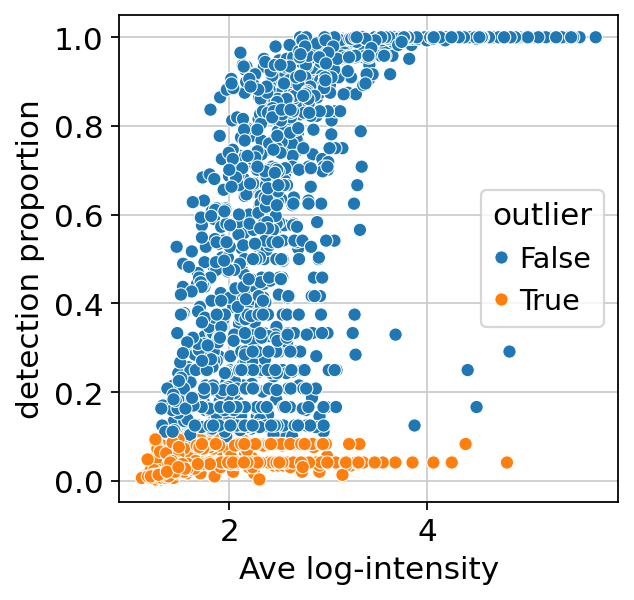

In [9]:
ax = sns.scatterplot(data = scF_df, x='x', y='y', hue= 'outlier')
ax.set(xlabel='Ave log-intensity', ylabel='detection proportion')
plt.show()

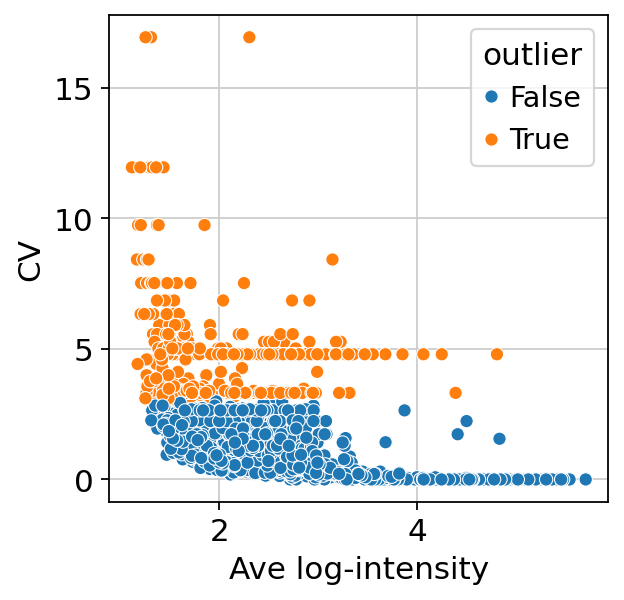

In [10]:
ax = sns.scatterplot(data = scF_df, x='x', y='cv', hue= 'outlier')
ax.set(xlabel='Ave log-intensity', ylabel='CV')
plt.show()

Remove outlier proteins.

In [11]:
adata = adata[:,~scF_df.outlier].copy()
adata_booster = adata_booster[:, adata.var_names].copy()

Compute cv.

In [12]:
sample_cv = adata.to_df().copy().groupby(adata.obs['File ID'].values).apply(lambda x: np.nanstd(x)/np.nanmean(x), )

sample_cv = sample_cv.to_dict()
adata.obs['sample_cv'] = adata.obs['File ID'].map(sample_cv).values

Only keep channel 126. Why?

In [13]:
adata_booster = adata_booster[adata_booster.obs.Channel.isin(['126'])].copy()

In [14]:
adata_booster.X = adata_booster.layers["raw"].copy()
adata_booster.X[np.isnan(adata_booster.X)] = 0

batch_continous_info = adata_booster.X

In [15]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [16]:
protvi.model.PROTVI.setup_anndata(adata,
                     # batch_key = "Column",
                     batch_key = "File ID", # Plate as batch key did not remove plate effect
                     # batch_key="Channel",
                     categorical_covariate_keys = ['Channel'],
                     # categorical_covariate_keys = ['Channel', 'Column'], # 'Column'
                     # continuous_covariate_keys=["Num Proteins", "Log2 Sum S/N"],
                     # continuous_covariate_keys= ["Num Proteins", "sample_cv"],
                     # continuous_covariate_keys= ["sample_cv"],

                     # categorical_covariate_keys = ['File ID'],

                     # continuous_covariate_keys= ['sample_cv'],
                     # categorical_covariate_keys = ['Plate', 'Channel'],
                     # continuous_covariate_keys=["Log2 Sum S/N"], # "d2c", "Log2 Sum S/N", "Num Proteins"
                     # norm_continuous_covariate_keys = ['rle_norm'], # 'cv_offset', 'sample_cv', 'rle_norm'
                     # norm_continuous_covariate_keys = ['sample_cv'],

                     # prior_continuous_covariate_keys = ['CD34-APC-Cy7-A','CD38-PE-A'],
                     
                    )


In [17]:
# model = protvi.model.PROTVI(adata_, log_variational=False,
#                             n_hidden=225, n_layers=1, # worked well last with 128
#                             n_latent = 20, #n_latent = 5,
#                             decoder_type = 'selection',
#                             encode_norm_factors=False,
#                             use_x_mix=False,
#                             # batch_embedding_type="embedding",
#                             # batch_dim=20,
#                             # batch_continous_info = batch_continous_info,
                           
#                             # detection_trend = "per-batch"
#                            ) 



model = protvi.model.PROTVI(adata, log_variational=False,
                            n_hidden=225, n_layers=1, # worked well last with 128
                            n_latent = 30, #n_latent = 5,
                            decoder_type = 'selection',
                            encode_norm_factors=False,
                            use_x_mix=False,
                            batch_embedding_type="encoder",
                            batch_dim=20, # there are overall 24 runs
                            batch_continous_info = batch_continous_info,
                           
                            # detection_trend = "per-batch"
                           ) 

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [18]:
# model.train(max_epochs=10000, plan_kwargs={"mechanism_weight": 0.9, 'kl_weight':1}, check_val_every_n_epoch=120) 
model.train(max_epochs=5000, plan_kwargs={"mechanism_weight":1e-2, 'kl_weight':1, #  1e-3
                                         'n_epochs_kl_warmup': 10}, check_val_every_n_epoch=120) # batch_size = 64 

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 5/5000:   0%|          | 4/5000 [00:00<03:42, 22.48it/s, v_num=1, train_loss_step=3.89e+3, train_loss_epoch=4.28e+3]

/home/rasmus/rmls/work/ra/MS_mv_modelling/src/protvi/model/_protvae.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_encoding = self.batch_encoder(torch.tensor(batch_input, dtype=z.dtype, device=z.device))
/home/rasmus/rmls/work/ra/MS_mv_modelling/src/protvi/model/_protvae.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_encoding = self.batch_encoder(torch.tensor(batch_input, dtype=z.dtype, device=z.device))
/home/rasmus/rmls/work/ra/MS_mv_modelling/src/protvi/model/_protvae.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

Epoch 124/5000:   2%|▏         | 123/5000 [00:05<04:34, 17.77it/s, v_num=1, train_loss_step=1.11e+3, train_loss_epoch=776]  

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/rasmus/rmls/work/ra/MS_mv_modelling/src/protvi/model/_protvae.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_encoding = self.batch_encoder(torch.tensor(batch_input, dtype=z.dtype, device=z.device))


Epoch 5000/5000: 100%|██████████| 5000/5000 [04:49<00:00, 14.55it/s, v_num=1, train_loss_step=245, train_loss_epoch=-69.6]     

INFO: `Trainer.fit` stopped: `max_epochs=5000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 5000/5000: 100%|██████████| 5000/5000 [04:49<00:00, 17.29it/s, v_num=1, train_loss_step=245, train_loss_epoch=-69.6]


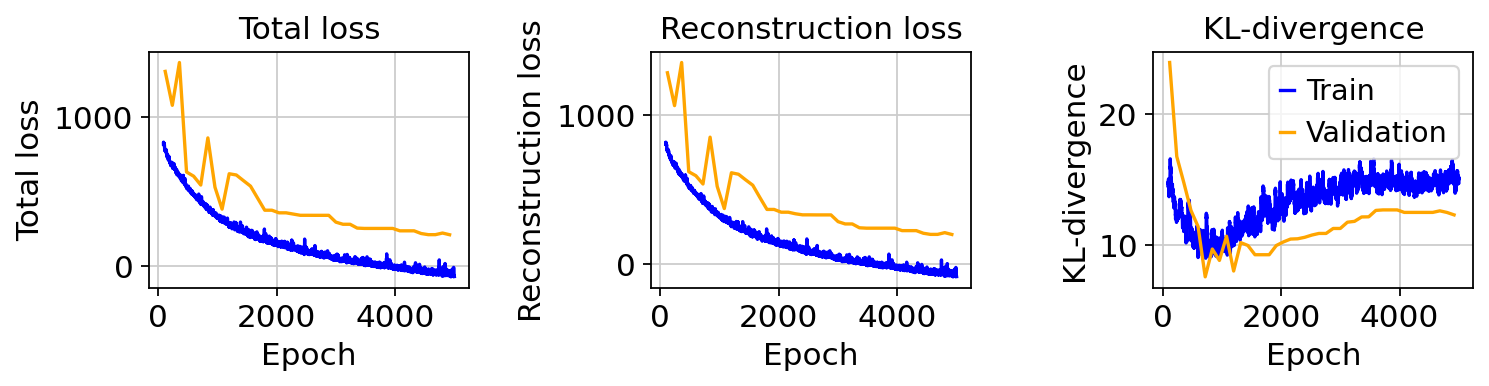

In [19]:
pl.plot_loss(model.history, epoch_start=90, validation_smooth_window=10)

In [20]:
model.save("protvi")

In [17]:
model = protvi.model.PROTVI.load("protvi", adata)

INFO     File protvi/model.pt already downloaded                                                                   


/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(

In [18]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

In [19]:
adata_latent = sc.AnnData(X = latent, obs = adata.obs)
sc.pp.pca(adata_latent)
adata.obsm['latent_X_pca'] = adata_latent.obsm['X_pca']

computing PCA
    with n_comps=29
    finished (0:00:00)


In [20]:
sc.pp.neighbors(adata, use_rep="latent", n_neighbors = 10)
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


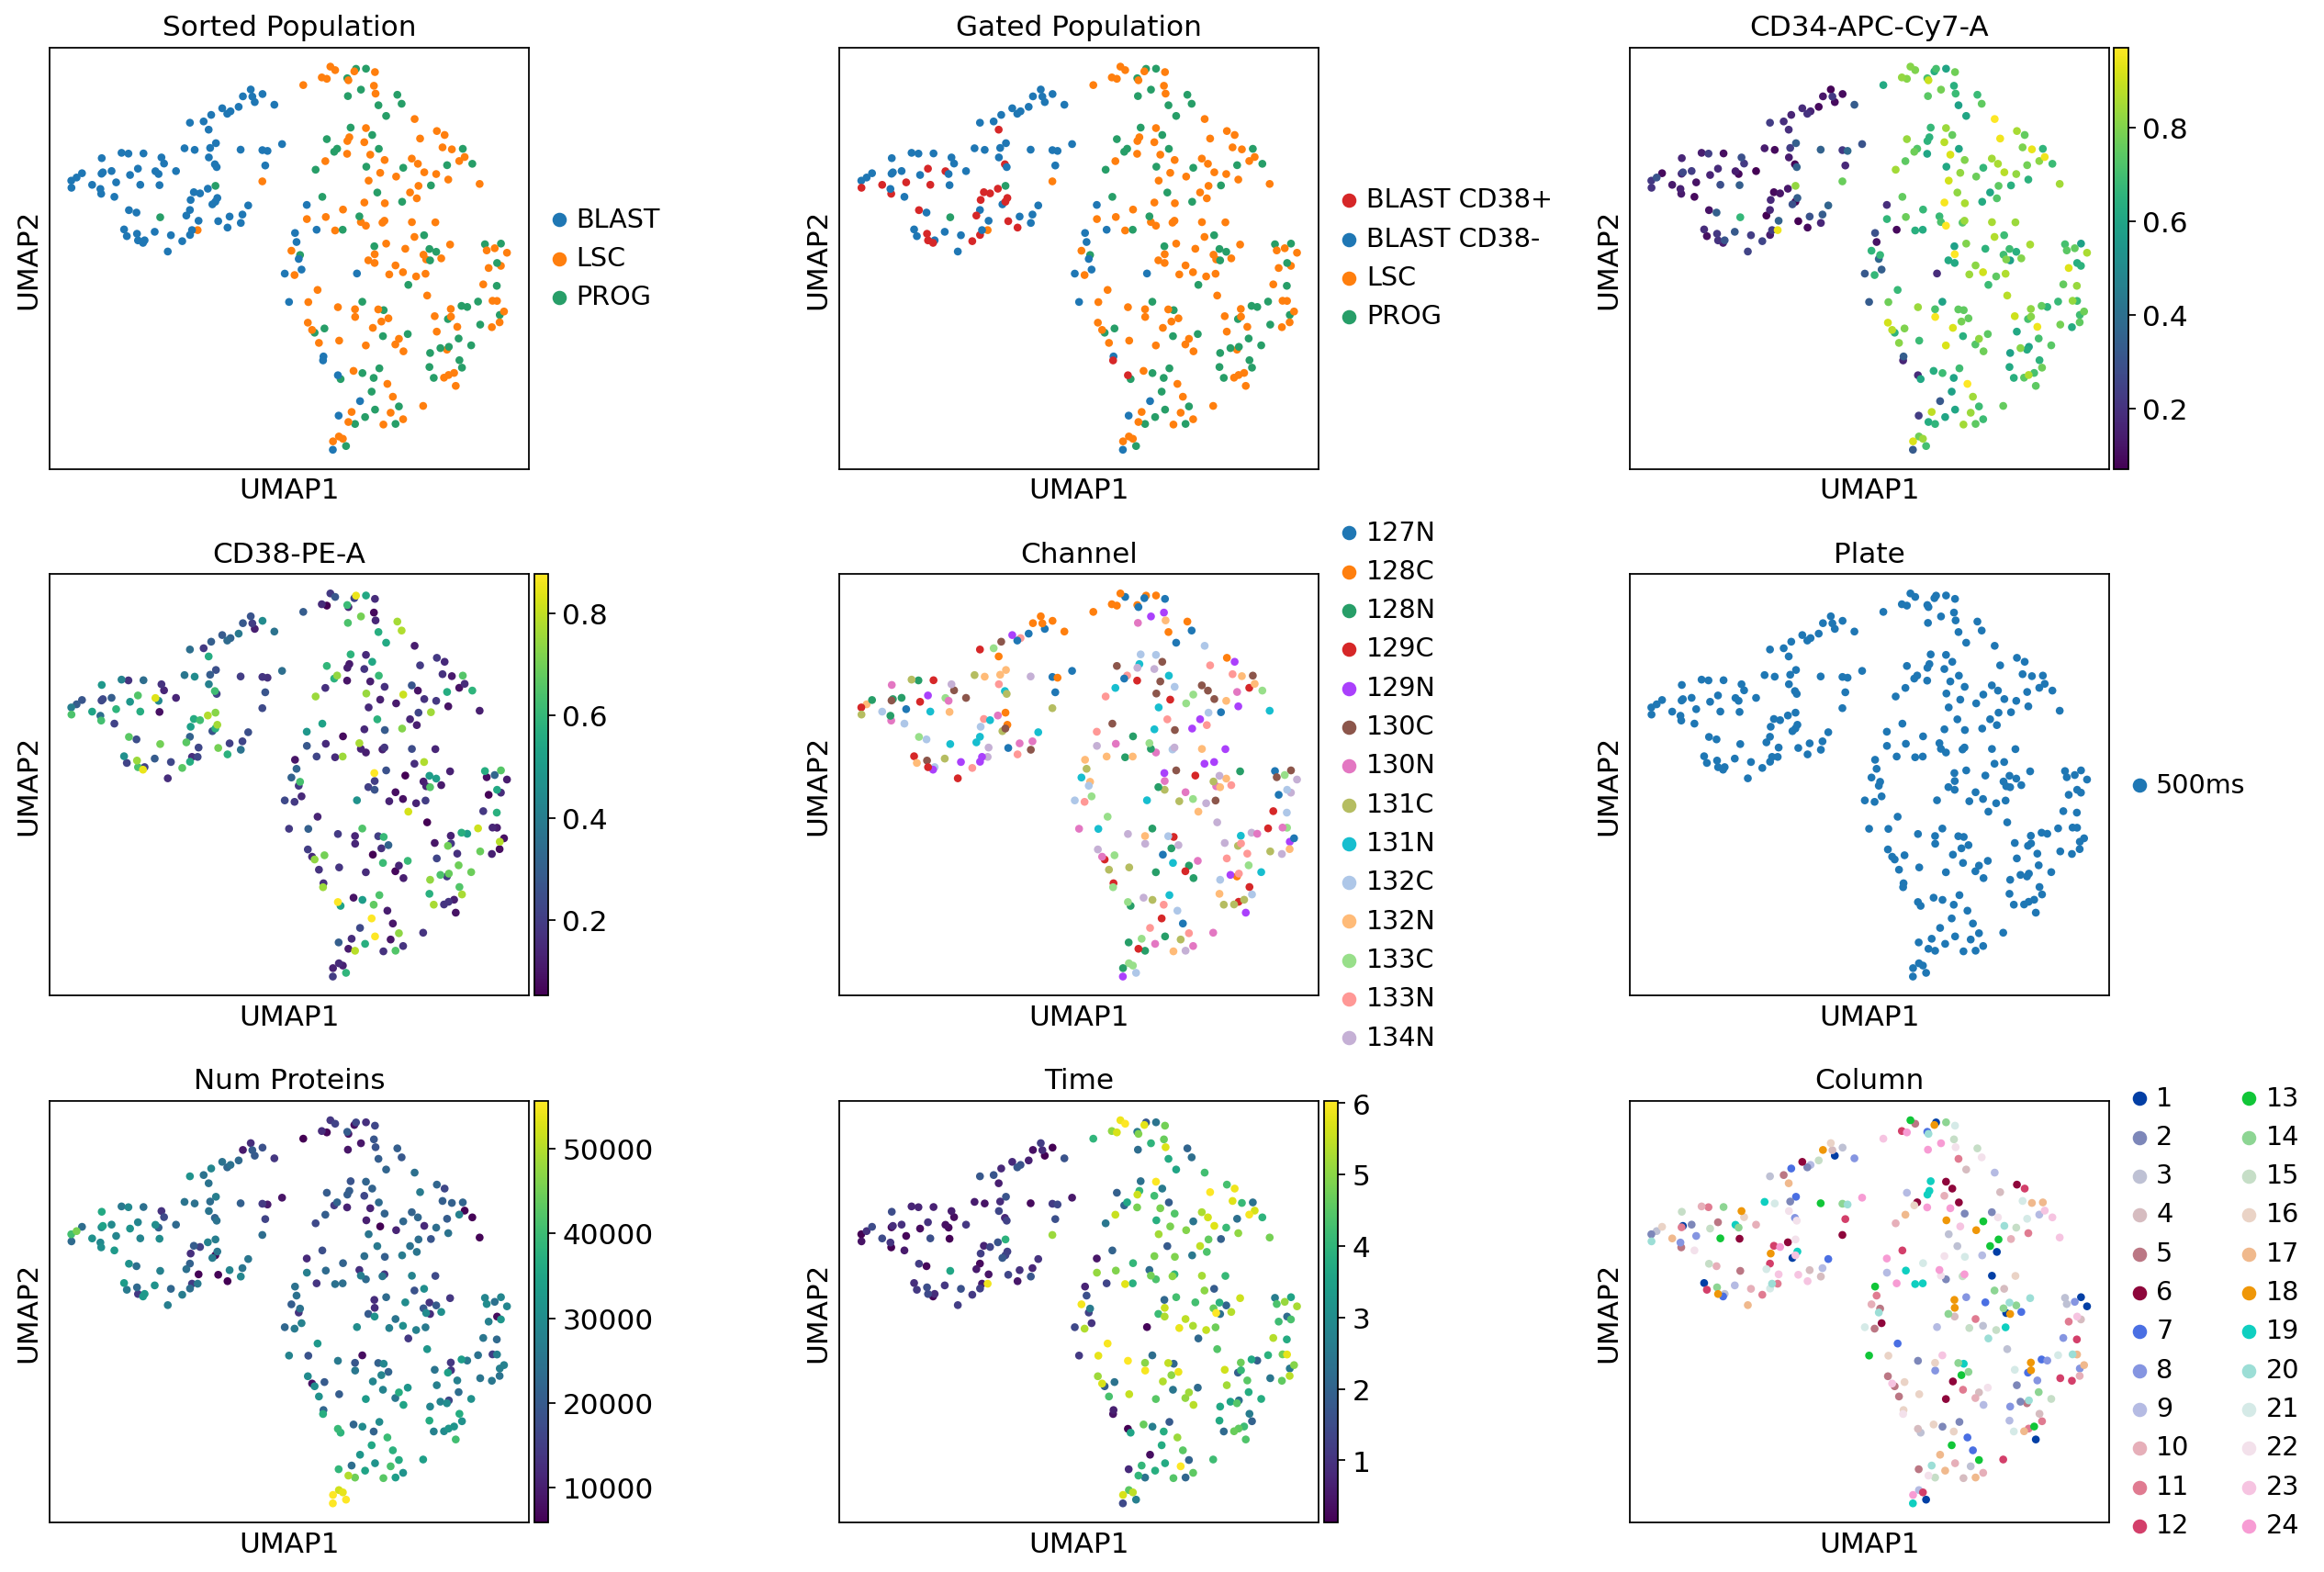

In [21]:
sc.pl.umap(
    adata, 
    color=['Sorted Population',
        "Gated Population", "CD34-APC-Cy7-A", "CD38-PE-A",
        "Channel", "Plate",  "Num Proteins", "Time", "Column"
        ], 
    vmin="p01", vmax="p99",ncols = 3, wspace = 0.5, size = 60,
)

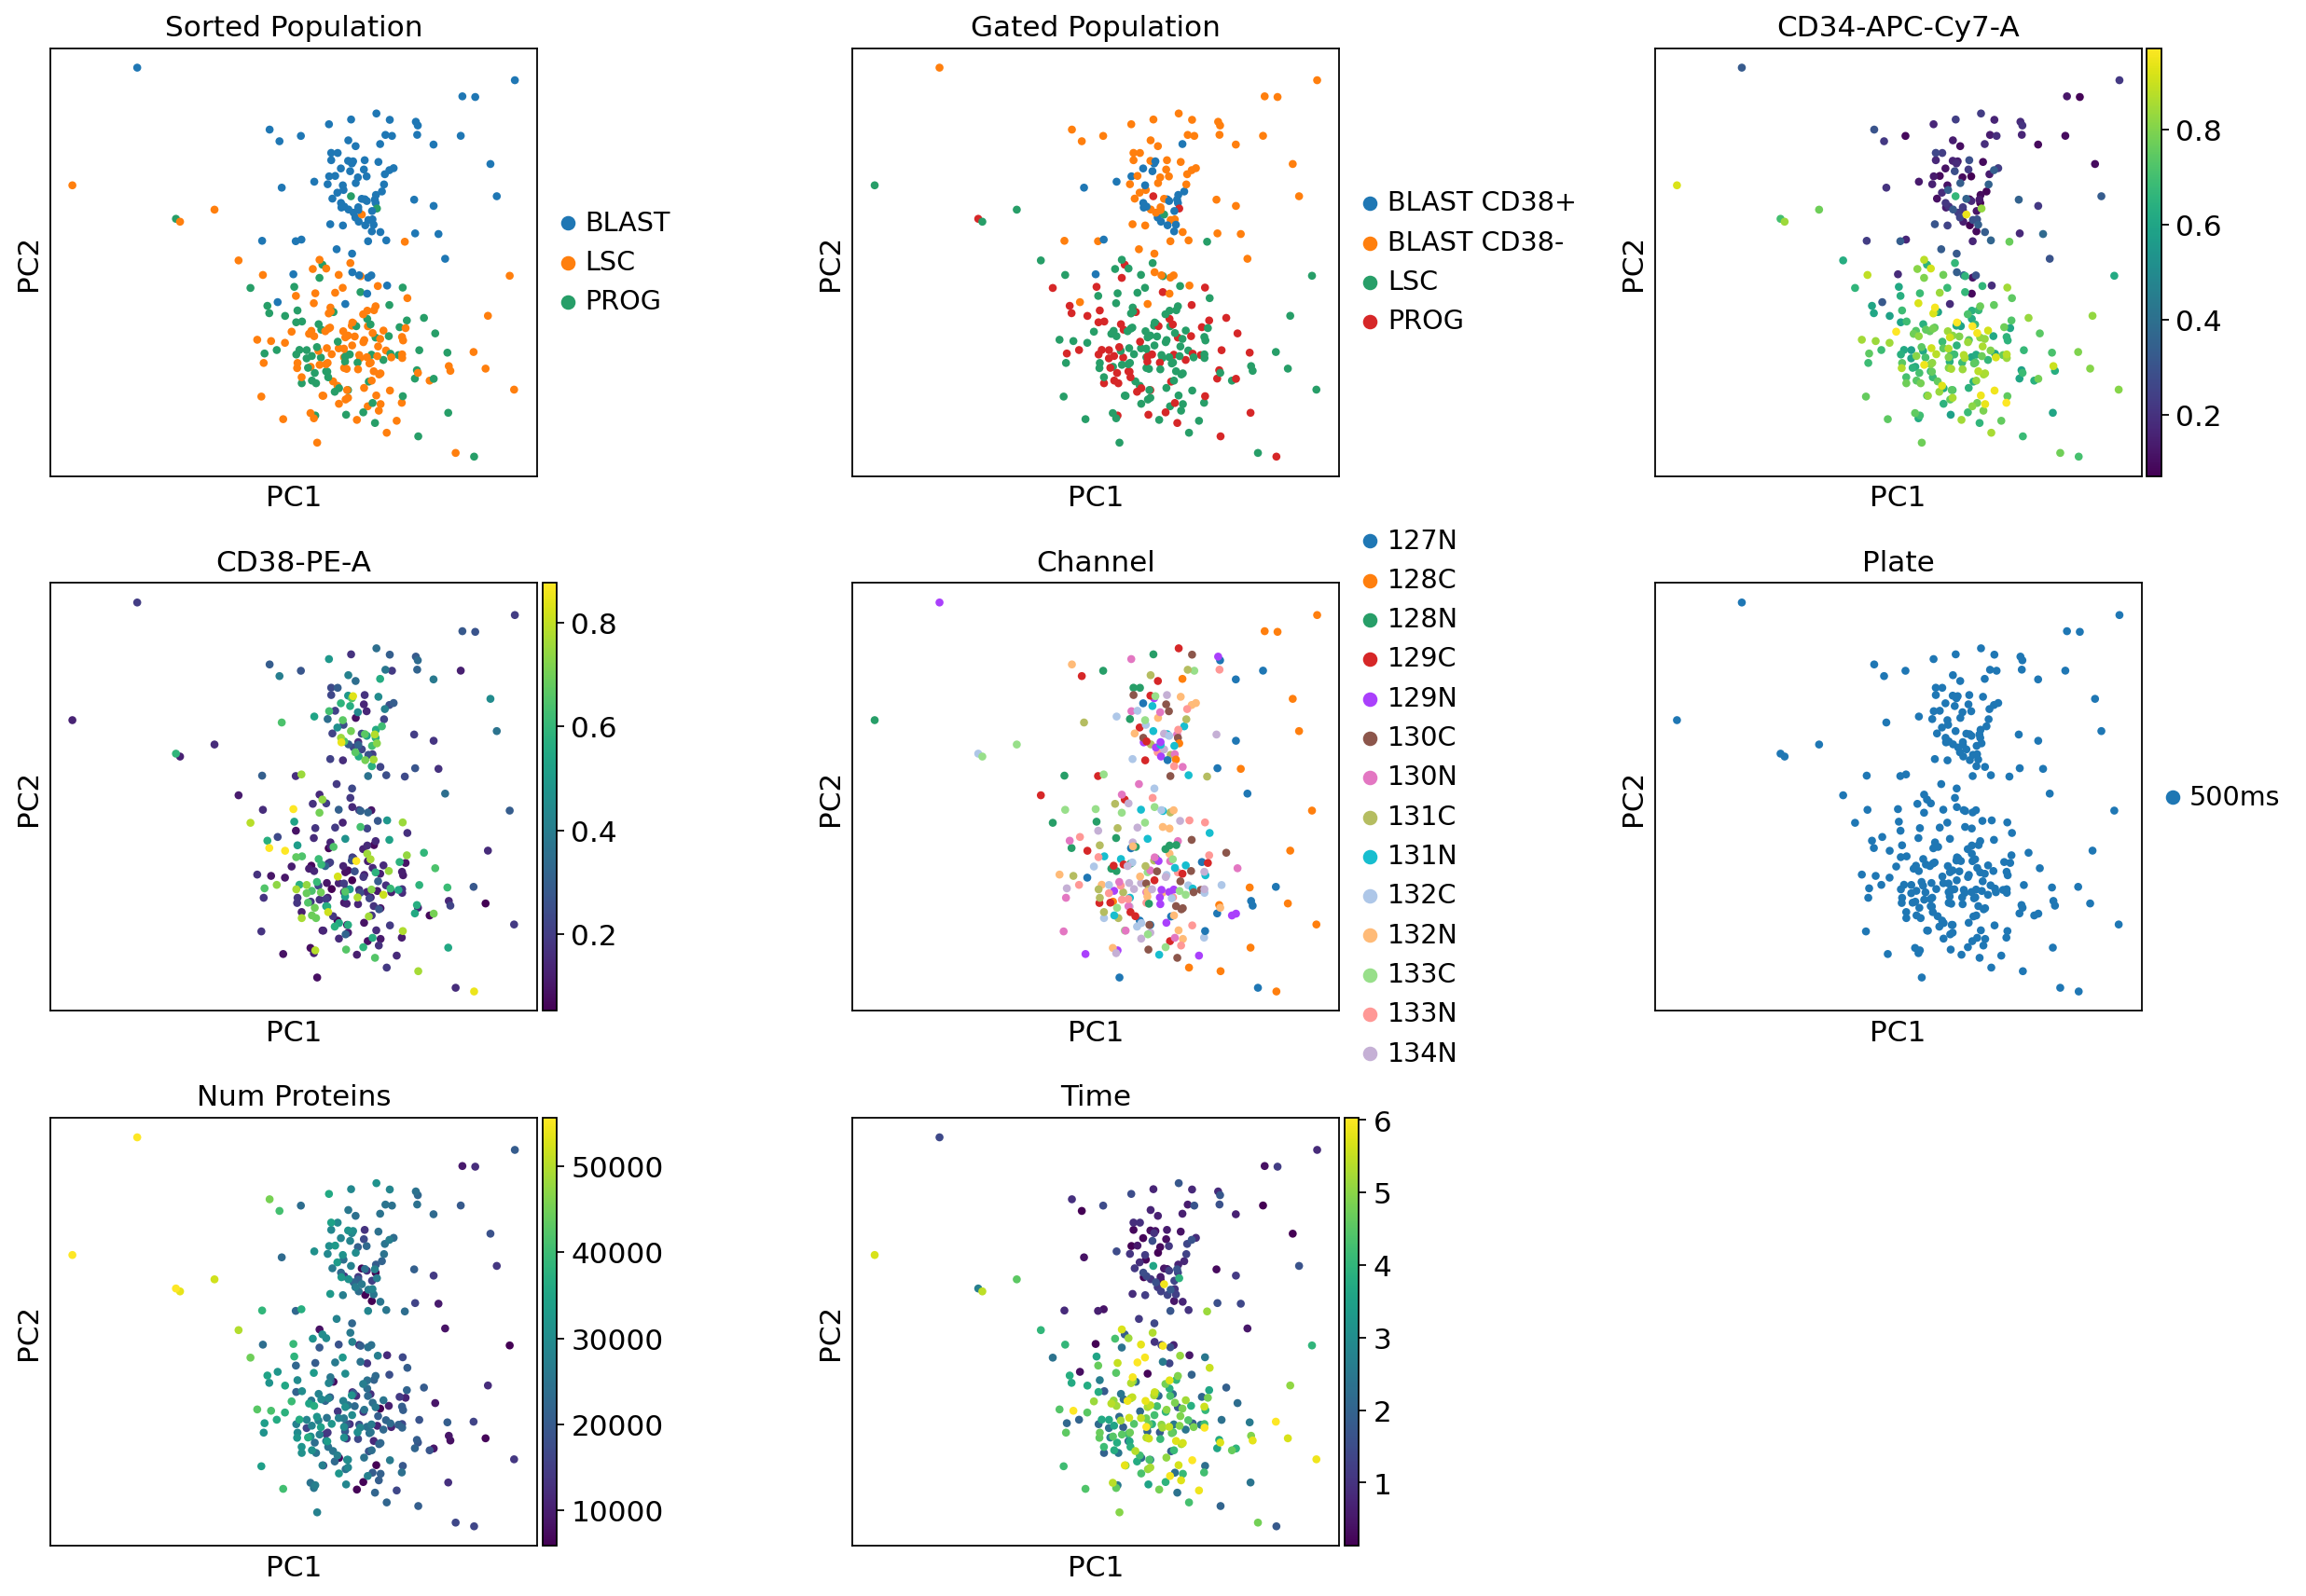

In [22]:
sc.pl.pca(
    adata_latent, 
    color=['Sorted Population',
        "Gated Population", "CD34-APC-Cy7-A", "CD38-PE-A",
        "Channel", "Plate",  "Num Proteins", "Time"
        ], 
    vmin="p01", vmax="p99",ncols = 3, wspace = 0.5, size = 60,
)

In [23]:
#sc.pl.embedding(
#    adata, 
#    basis = 'sceptre_X_pca',
#    color=['Sorted Population',
#        "Gated Population", "CD34-APC-Cy7-A", "CD38-PE-A",
#        "Channel", "Plate",  "Num Proteins", "Log2 Sum S/N", 
#        ], 
#    vmin="p01", vmax="p99",ncols = 3, wspace = 0.5, size = 60,
#)

Plot the detection probability trend.

In [24]:
x_est, p_est = model.impute(n_samples=adata.n_obs, batch_size=1)

x_data = adata.layers["raw"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_data)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_data)] = np.nan

/home/rasmus/rmls/work/ra/MS_mv_modelling/src/protvi/model/_protvae.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_encoding = self.batch_encoder(torch.tensor(batch_input, dtype=z.dtype, device=z.device))


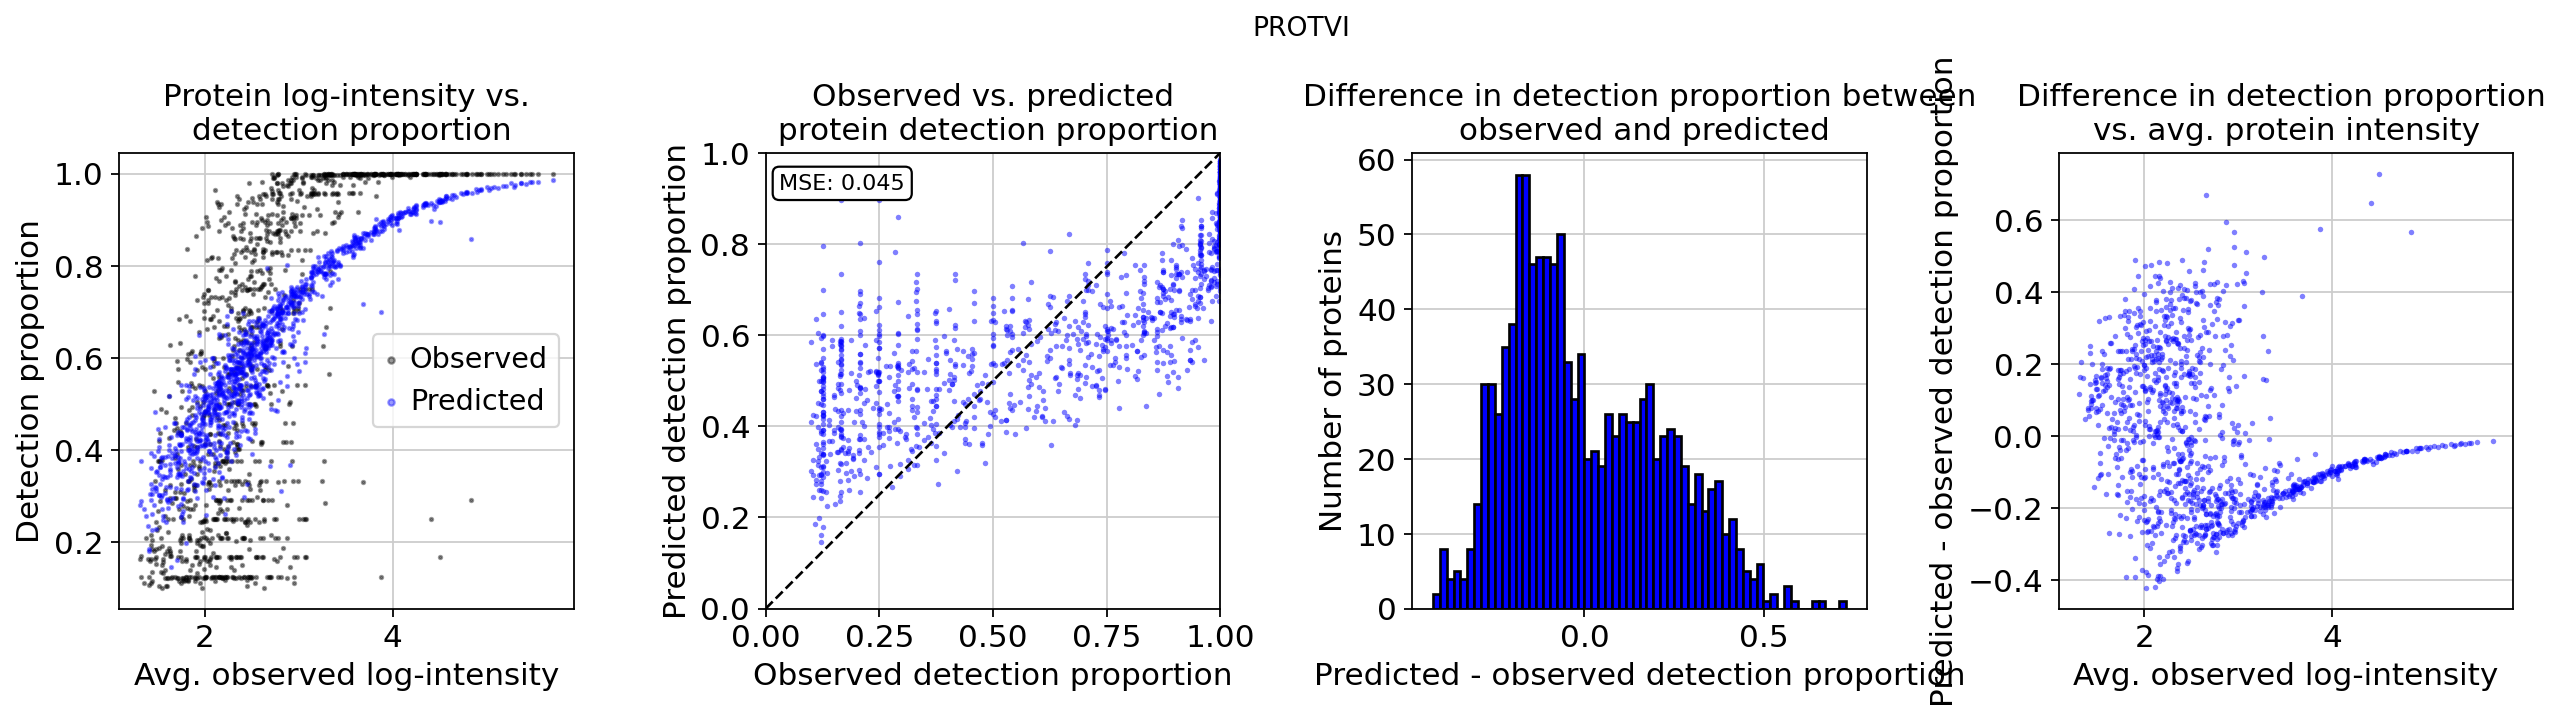

In [25]:
pl.plot_protein_detection_proportion_panel(x_data, p_est, title="PROTVI")

In [26]:
detections = np.mean(p_est, axis=0)
ave_exp = np.nanmean(adata.layers['raw'], axis=0)

mu_smooth, p_smooth = smoothing(ave_exp, detections, lowess_frac=0.3)

x_dict = {}
yloess_dict = {}

x_dict['protVI'] = mu_smooth
yloess_dict['protVI'] = p_smooth

## protDP


Let's also train [protDP](https://mengbo-li.github.io/protDP/index.html) for later comparison.


In [27]:
adata.X = adata.layers["raw"].copy()

In [28]:
%%capture
protdp_result = run_protDP(adata)

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /usr/lib/R
INFO:rpy2.situation:R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
INFO:rpy2.situation:LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.

 

 

 



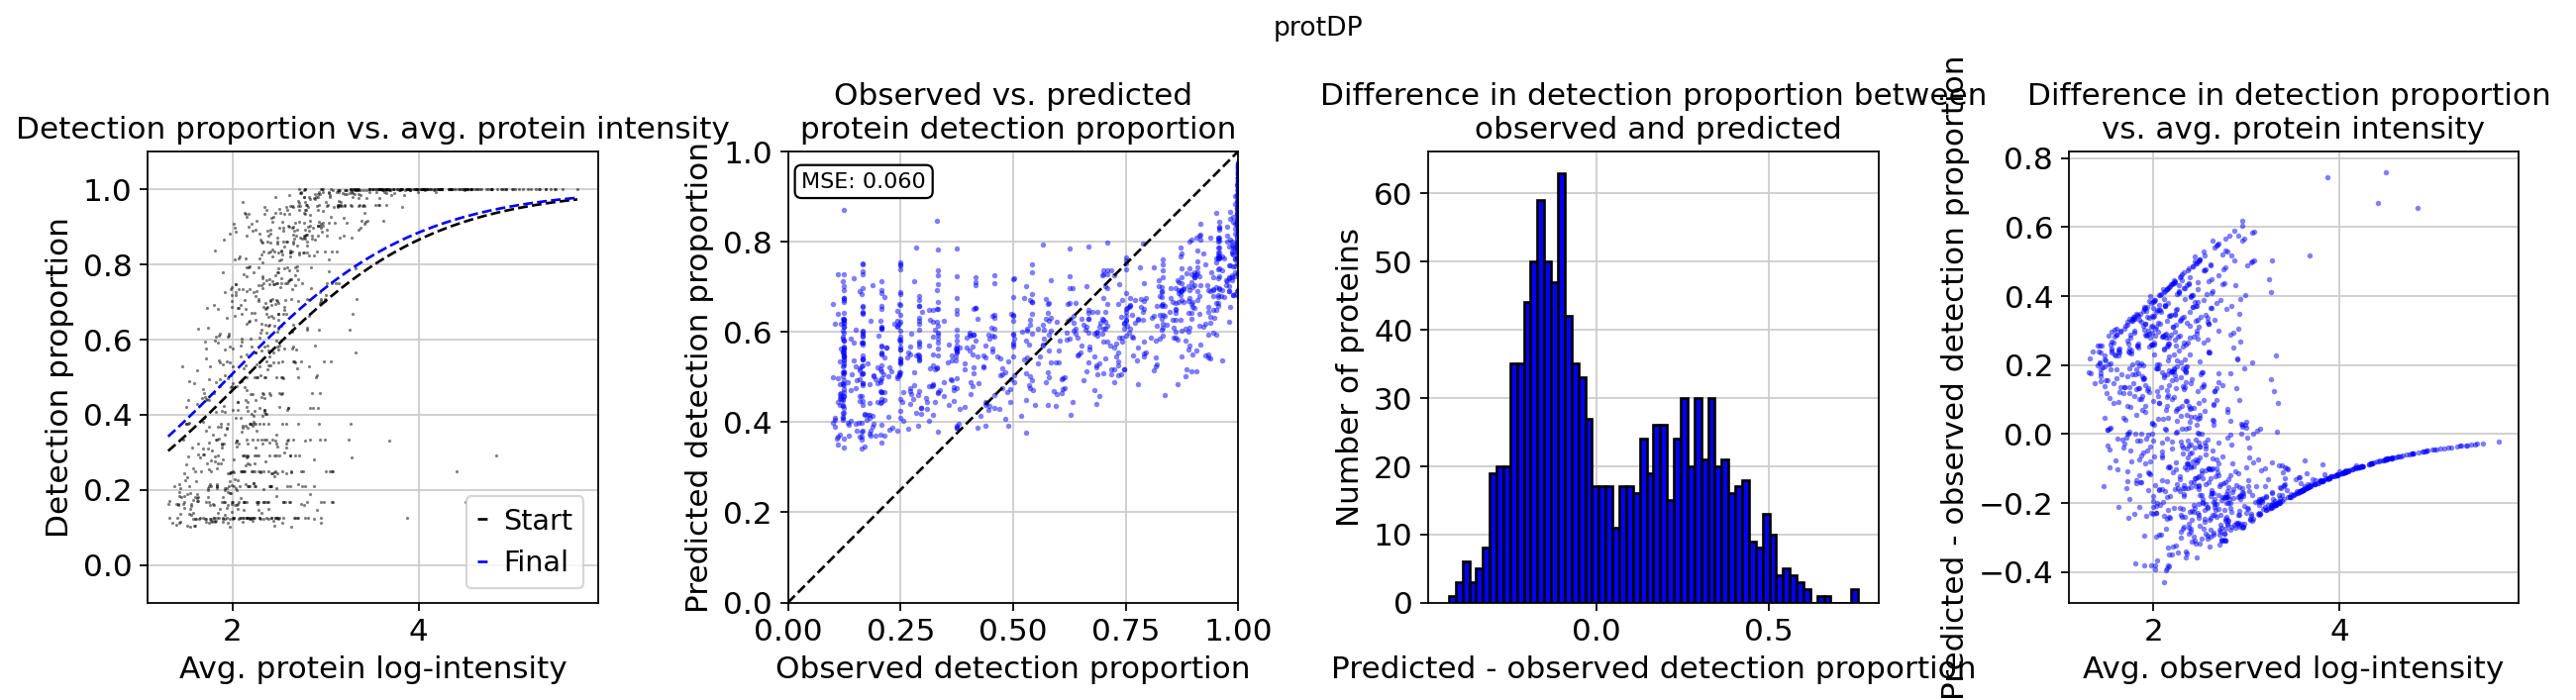

In [29]:
pl.plot_protein_detection_proportion_panel_protDP(adata.X, protdp_result, title="protDP")

In [30]:
PROTDP_OUTPUT_NAME = "schoof2021_sceptre_protdp.pkl"

import pickle

with open(PROTDP_OUTPUT_NAME, 'wb') as f:
    pickle.dump(protdp_result, f)

Plot global detection curves.

In [31]:
x = adata.layers['raw'].copy()

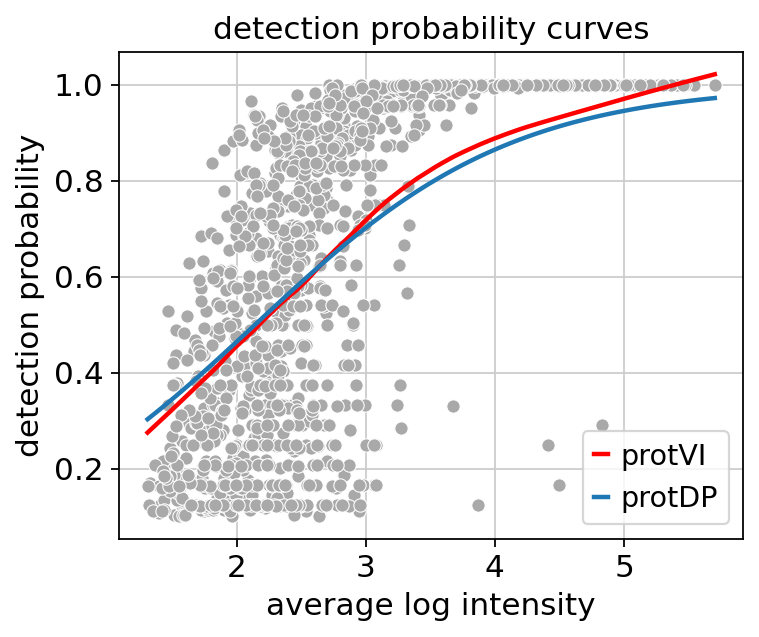

In [32]:
x_protein = np.nanmean(x, axis=0)
p_protein = 1 - np.mean(np.isnan(x), axis=0)
p_est_protein = p_est.mean(axis=0)

fig, ax = plt.subplots(figsize=(5, 4), ncols=1)
ax = sns.scatterplot(x=x_protein, y=p_protein, color="darkgrey")

# protVI
idx = np.argsort(x_dict['protVI'])
ax.plot(x_dict['protVI'][idx], yloess_dict['protVI'][idx], label="protVI", linewidth=2, color='red')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# protDP
intercept, slope = protdp_result["betaStart"] # for some reason the corrected beta is odd, so use the uncorrected. 
xs = np.linspace(np.min(x_protein), np.max(x_protein), 100)
ys = sigmoid(slope * xs + intercept)
ax.plot(xs, ys, label="protDP", linewidth=2)
ax.legend()

ax.set_xlabel("average log intensity")
ax.set_ylabel("detection probability")
ax.set_title("detection probability curves")

plt.savefig("schoo2021_sceptre_detection_probability_curves.svg")

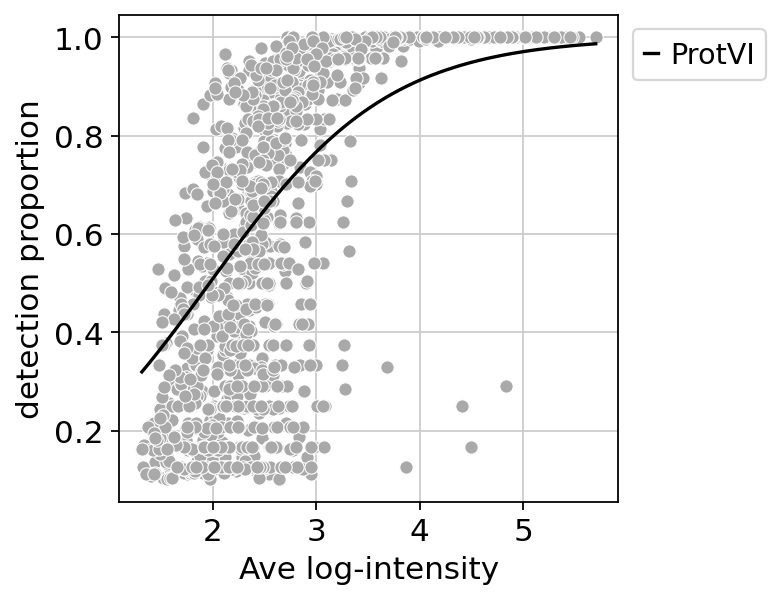

In [37]:
pl.plot_detection_curve(model, adata)

In [39]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [40]:
bm = Benchmarker(
    adata,
    batch_key="File ID",
    label_key= "Gated Population", # "Sorted Population"
    #embedding_obsm_keys=['sceptre_X_pca', "latent","latent_X_pca"], # 'X_umap', 'sceptre_X_umap'
    embedding_obsm_keys=["latent","latent_X_pca"], # 'X_umap', 'sceptre_X_umap'
    n_jobs=6,
)
bm.benchmark()

computing PCA
    with n_comps=50


/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:00)


Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]INFO:root:isolated labels: no more than 18 batches per label
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
Embeddings: 100%|██████████| 2/2 [00:05<00:00,  2.73s/it]


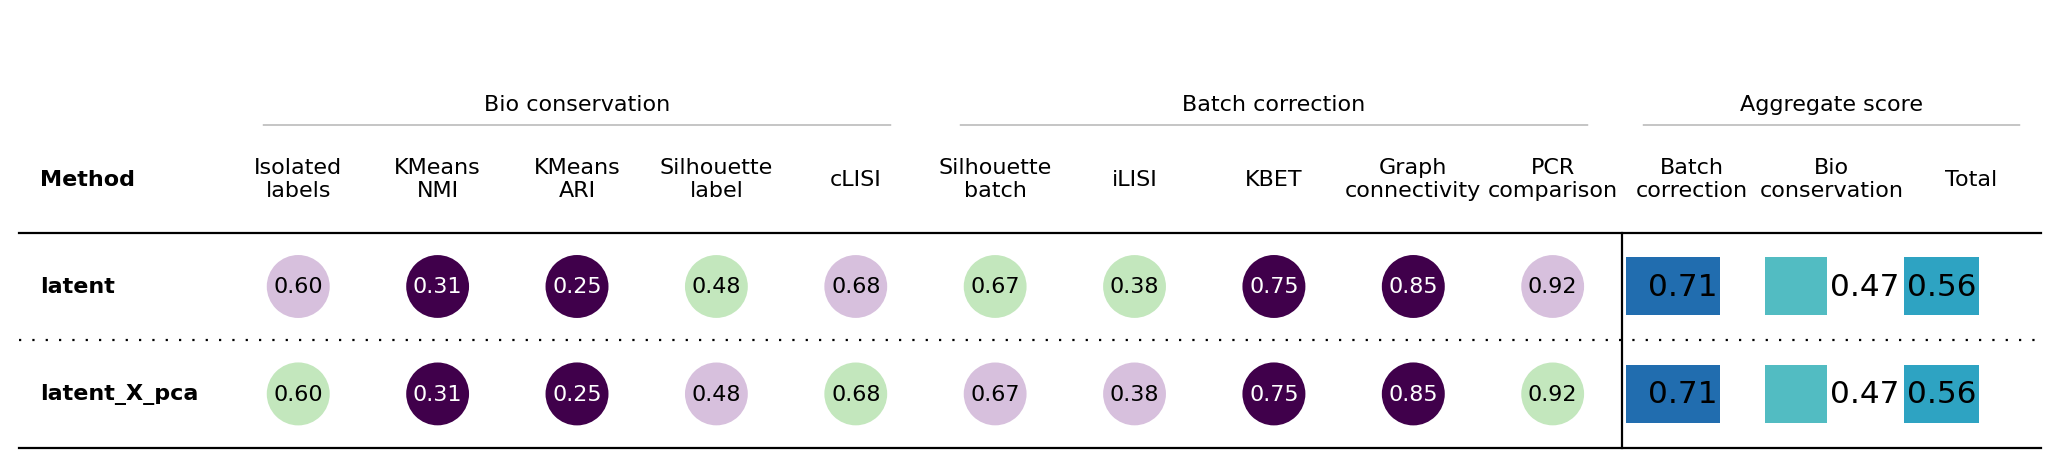

In [ ]:
bm.plot_results_table(min_max_scale=False) 